# *Survival on the Titanic: A Machine Learning Approach to Predicting Passenger Fate*

# Problem Formulation

The goal of this project is to build a predictive model that determines whether a passenger survived the Titanic shipwreck based on a variety of demographic and onboard features.

The dataset originates from the 1912 sinking of the RMS Titanic, one of the deadliest commercial maritime disasters in history. Of the approximately 2,224 passengers and crew aboard, more than 1,500 perished. Survival outcomes were influenced by various social and logistical factors such as gender, age, passenger class, and access to lifeboats.

The dataset provided by Kaggle’s Titanic: Machine Learning from Disaster competition includes features like:

	•	Pclass (ticket class)
 
	•	Sex (biological gender)
 
	•	Age
 
	•	SibSp (number of siblings/spouses aboard)
 
	•	Parch (number of parents/children aboard)
 
	•	Fare (ticket fare)
 
	•	Embarked (port of embarkation)
 
	•	Cabin, Ticket, and Name (which may require additional preprocessing)

**Prediction Task**

This is a binary classification problem:
We aim to predict the target variable Survived, where:

	•	1 = the passenger survived
 
	•	0 = the passenger did not survive

The task is well-suited to applying a range of machine learning models — from logistic regression to more complex ensemble methods. Evaluation metrics such as accuracy, precision, recall, and ROC-AUC will be used to assess model performance.


# Data Preparation and Feature Engineering

To train an accurate and robust classification model, we first clean and transform the Titanic dataset. This process involves handling missing values, engineering useful features, and selecting variables that are relevant for predicting survival.

### Summary Statistics

Before training the model, we performed an initial exploratory data analysis to understand the distribution and central tendencies of numerical features such as `Age`, `Fare`, and `SibSp`.

The summary statistics below reveal useful insights about the spread and skewness of these variables, which informs our feature engineering and imputation decisions.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("train.csv")

# Display summary statistics
df[['Age', 'Fare', 'SibSp']].describe()

,Age,Fare,SibSp
count,714.000000,891.000000,891.000000
mean,29.699118,32.204208,0.523008
std,14.526497,49.693429,1.102743
min,0.420000,0.000000,0.000000
25%,20.125000,7.910400,0.000000
50%,28.000000,14.454200,0.000000
75%,38.000000,31.000000,1.000000
max,80.000000,512.329200,8.000000


- **Age** has a mean of around 29 years, with a minimum of 0.42 and a maximum of 80. The standard deviation is 14.5, indicating a wide spread in passenger ages. Some missing values exist, which will be handled later.
- **Fare** is highly skewed with a large range (min = 0, max = 512), indicating the presence of outliers and unequal fare distribution among passengers.
- **SibSp** (number of siblings/spouses aboard) has a low mean and low standard deviation, suggesting most passengers were traveling alone or with a single companion.

### Visual Exploration of Numerical Features

We visualized key numerical features using histograms and boxplots to better understand their distributions. This helps detect skewness, outliers, and informs transformations or binning strategies.

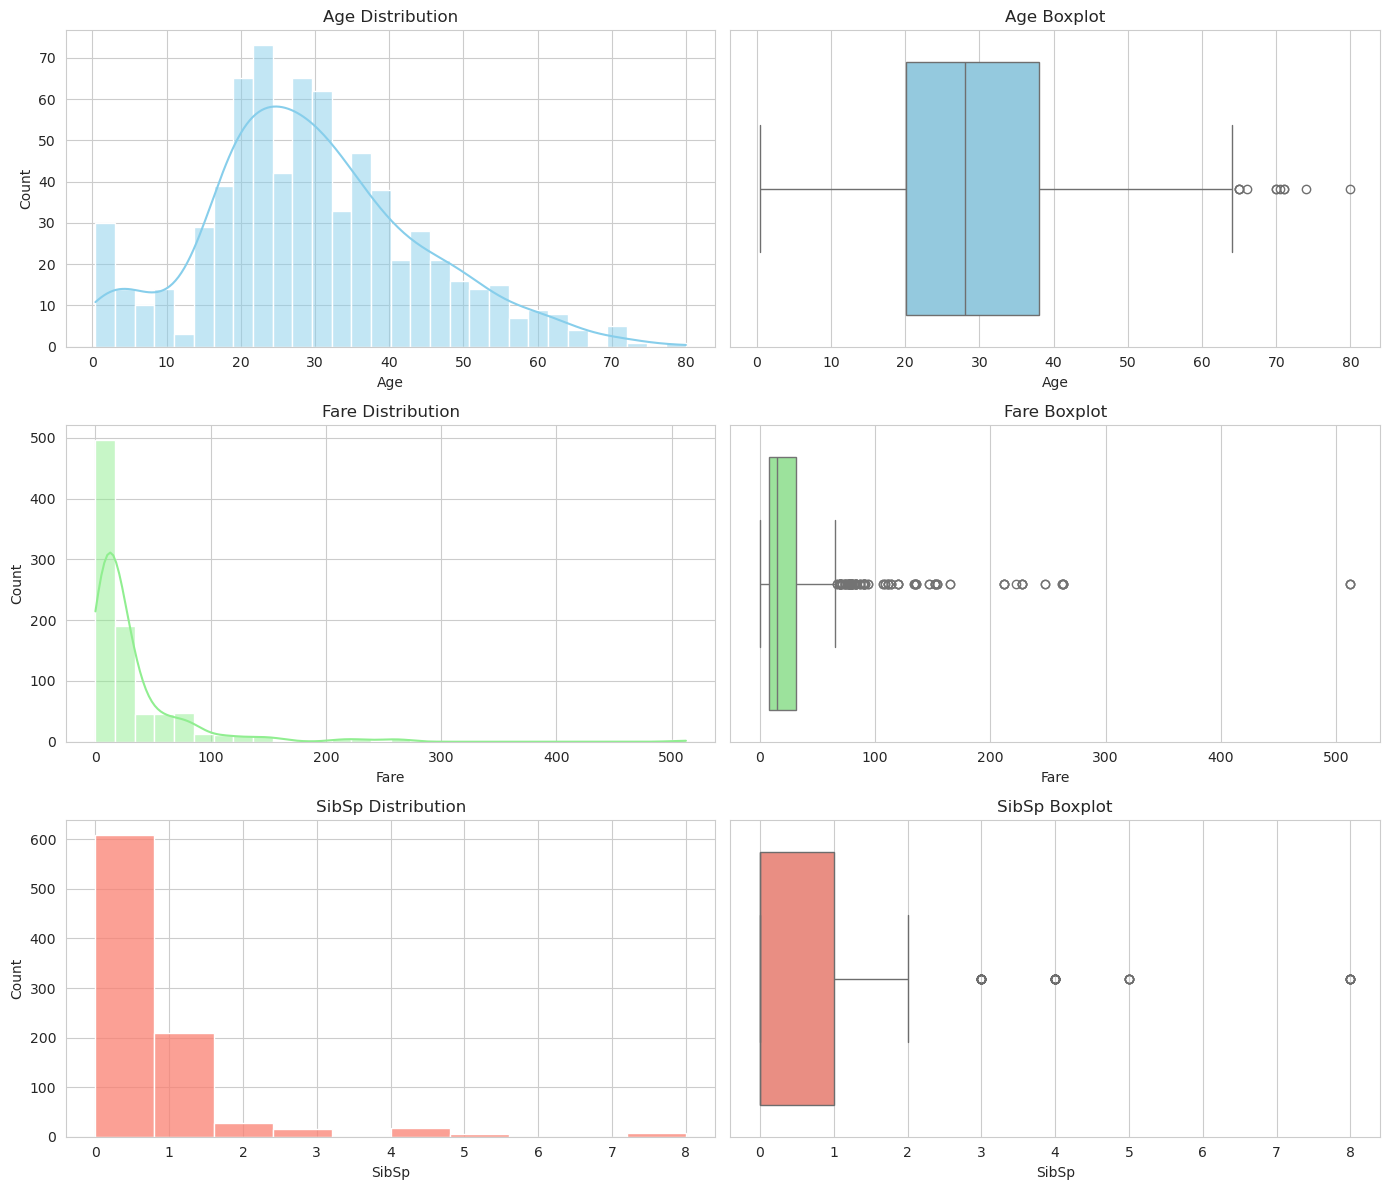

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Plot histograms and boxplots for Age, Fare, and SibSp
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Age
sns.histplot(df['Age'].dropna(), bins=30, kde=True, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title("Age Distribution")
sns.boxplot(x=df['Age'], ax=axes[0, 1], color="skyblue")
axes[0, 1].set_title("Age Boxplot")

# Fare
sns.histplot(df['Fare'], bins=30, kde=True, ax=axes[1, 0], color="lightgreen")
axes[1, 0].set_title("Fare Distribution")
sns.boxplot(x=df['Fare'], ax=axes[1, 1], color="lightgreen")
axes[1, 1].set_title("Fare Boxplot")

# SibSp
sns.histplot(df['SibSp'], bins=10, kde=False, ax=axes[2, 0], color="salmon")
axes[2, 0].set_title("SibSp Distribution")
sns.boxplot(x=df['SibSp'], ax=axes[2, 1], color="salmon")
axes[2, 1].set_title("SibSp Boxplot")

plt.tight_layout()
plt.show()

### Feature Distribution Insights

The exploratory data analysis of key numeric features reveals several important patterns:

- **Age**:  
  The age distribution is **right-skewed**, with a peak around 20–30 years. The boxplot confirms several outliers above 60, though most passengers fall within the 20–40 range. This may suggest that younger adults were the predominant demographic onboard.

- **Fare**:  
  The fare distribution is **highly right-skewed**, with a majority paying lower fares while a few extreme values inflate the scale. This is also evident in the boxplot, where numerous outliers exist beyond £100. These may correspond to first-class passengers.

- **SibSp (Siblings/Spouses Aboard)**:  
  Most passengers traveled **alone (0)** or with **one companion**. Very few had more than 2 siblings/spouses onboard, as reflected in both the distribution and boxplot. The outliers (values above 3) may warrant further investigation, though they could hold useful information about family survival patterns.

These insights justify feature engineering choices, such as binning `Age` or creating family-related variables. Skewed distributions like Fare may also benefit from log transformation to stabilize variance and reduce the impact of outliers on the model.

### Initial Exploration

Before diving into cleaning, we take a look at the structure of the dataset.

In [3]:
# Overview of the dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This reveals that the dataset includes 891 rows and 12 columns. Some variables have missing values—most notably Age, Cabin, and Embarked.

#### **Identify Missing Values**

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We observe missing values in the following columns:

	•	Age (177 missing)
 
	•	Cabin (687 missing)
 
	•	Embarked (2 missing)

Due to the large number of missing values in Cabin, we drop it. The others will be imputed.

#### **Drop Irrelevant or Redundant Features**

In [5]:
df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

We removed irrelevant or high-cardinality features such as `Cabin`, `Name`, and `Ticket` because:

- `Cabin` contains too many missing values to be useful without imputation.
- `Name` is a textual field with limited predictive value for survival.
- `Ticket` is a high-cardinality identifier that does not contribute meaningfully to the model.
- `PassengerId` is just an index.

Dropping these features helps reduce noise and simplifies the model.

#### **Impute Missing Values**

In [6]:
# Fill missing 'Age' values with the median
df['Age'].fillna(df['Age'].median(), inplace=True)

# The 'Embarked' column has already been one-hot encoded; no imputation needed here

/tmp/ipykernel_1429/160690366.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


We use median imputation for Age to reduce skewing and mode imputation for Embarked.

### Class Imbalance: Survival Distribution

/tmp/ipykernel_1429/3331213892.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette='Set2')


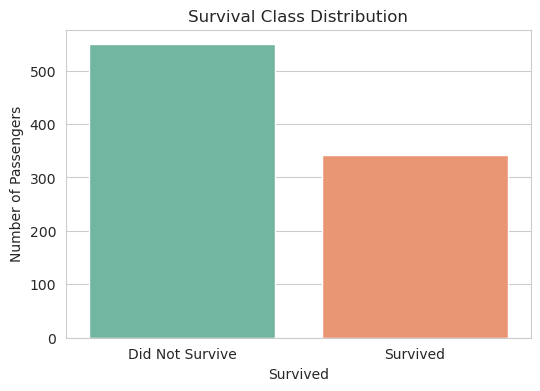

Passengers who did not survive: 549
Passengers who survived: 342


In [7]:
# Plot survival distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=df, palette='Set2')
plt.title('Survival Class Distribution')
plt.xlabel('Survived')
plt.ylabel('Number of Passengers')
plt.xticks([0, 1], ['Did Not Survive', 'Survived'])
plt.show()

# Print counts
survival_counts = df['Survived'].value_counts()
print("Passengers who did not survive:", survival_counts[0])
print("Passengers who survived:", survival_counts[1])

The dataset shows a **class imbalance**, with more passengers not surviving. Specifically:

- **Passengers who did not survive**: 549  
- **Passengers who survived**: 342

This imbalance may affect the model’s ability to correctly classify the minority class (survivors), and could justify the use of techniques like stratified sampling or class weights in future iterations.

### **Feature Engineering**

We extract useful insights from existing features:

#### **Encode Sex**

In [8]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

This binary encoding reflects the strong survival gender bias.

#### **Encode Embarked**

In [9]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

We one-hot encode the Embarked port to capture departure influence.

#### **Create Age Bins**

In [10]:
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
df['AgeBin'] = df['AgeBin'].astype('int')

Age groups may show different survival outcomes (e.g., children first policies).

#### **Create Family Size**

In [11]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

This feature accounts for the total number of family members on board.

#### **Is Alone**

In [12]:
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

Being alone may impact the chance of survival during chaos.

### **Data Visualization to Inform Feature Selection**

We visualize survival patterns for the most informative features:

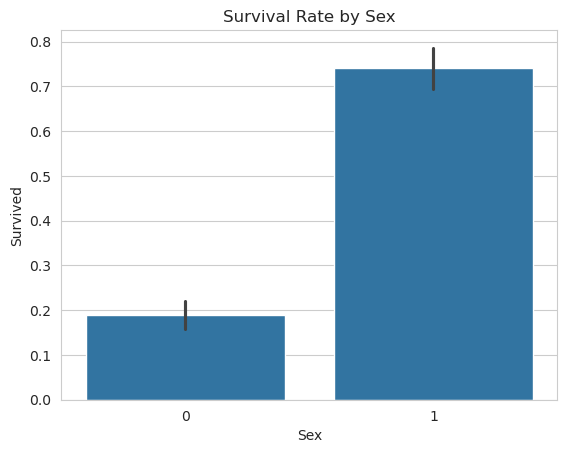

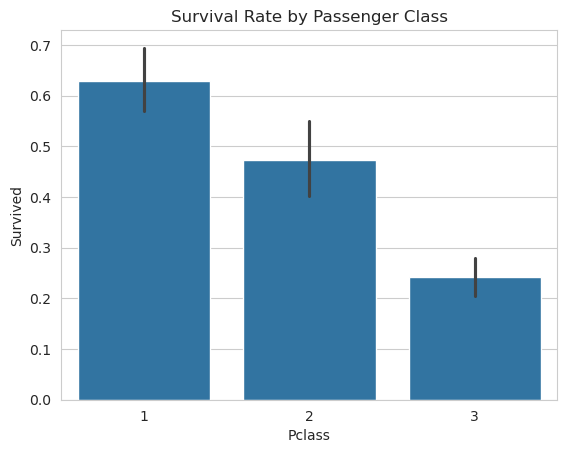

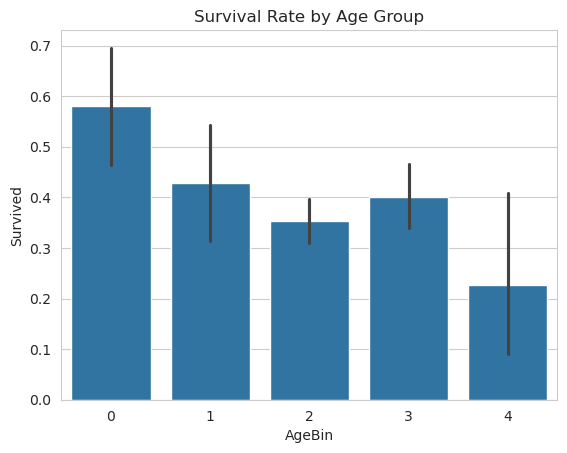

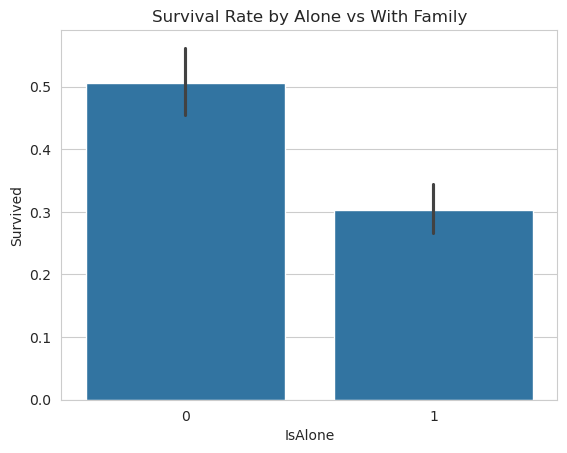

In [13]:
import numpy as np

sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival Rate by Sex')
plt.show()

sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.show()

sns.barplot(x='AgeBin', y='Survived', data=df)
plt.title('Survival Rate by Age Group')
plt.show()

sns.barplot(x='IsAlone', y='Survived', data=df)
plt.title('Survival Rate by Alone vs With Family')
plt.show()

### Interpretation of Class Widths in Visualizations

#### Survival Rate by Sex
- **Class `0`** → Represents **males**.
- **Class `1`** → Represents **females**.
- **Interpretation**: Females (1) had a significantly higher survival rate than males (0), reflecting social prioritization (e.g., *"women and children first"*).

#### Survival Rate by Passenger Class (`Pclass`)
- **Class `1`** → **1st class passengers** (wealthiest).
- **Class `2`** → **2nd class passengers** (middle class).
- **Class `3`** → **3rd class passengers** (lower class).
- **Interpretation**: Wealthier passengers had better access to lifeboats and faster evacuation, resulting in higher survival.

#### Survival Rate by Age Group (`AgeBin`)
- Age bins were created by splitting ages into **5 equal-width categories**:
  - **Bin `0`** → Youngest passengers.
  - **Bin `4`** → Oldest passengers.
- **Interpretation**: Younger passengers (Bin 0) had slightly higher survival, suggesting some prioritization for children.

#### Survival Rate by Alone vs. With Family (`IsAlone`)
- **Class `1`** → Passenger was **alone**.
- **Class `0`** → Passenger was **with family**.
- **Interpretation**: Passengers traveling with family (0) had a higher survival rate, possibly due to coordinated support and protection during evacuation.

These plots highlight key trends:

	•	Females had a much higher survival rate.
 
	•	1st-class passengers were more likely to survive.
 
	•	Children had a slightly better chance.
 
	•	Passengers traveling alone were less likely to survive.

#### **Final Feature Set**

After cleaning and feature engineering, the final set includes:

In [14]:
print(df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Q', 'Embarked_S', 'AgeBin', 'FamilySize', 'IsAlone'],
      dtype='object')


This forms the foundation for our modeling phase.

In [15]:
from sklearn.preprocessing import LabelEncoder

# Optional: round Fare to reduce noise
df['Fare'] = df['Fare'].round(2)

# Now df is clean and numeric
df_encoded = df.copy()

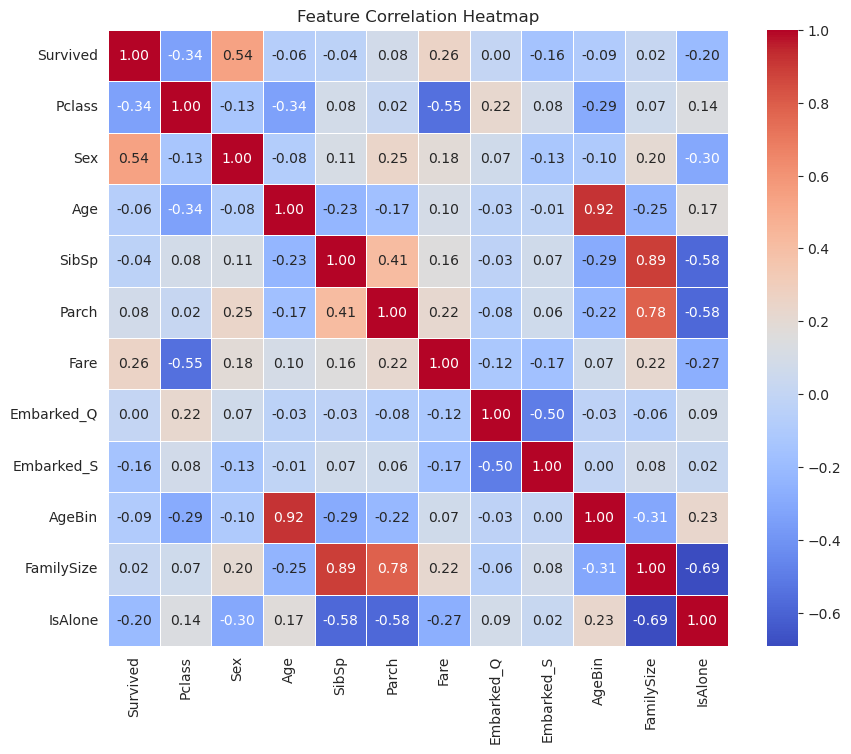

In [16]:
# Compute correlation matrix from the encoded dataframe
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Model Selection and Training

**Model Choice: K-Nearest Neighbors (KNN)**

For this classification task — predicting whether a Titanic passenger survived — we selected the K-Nearest Neighbors (KNN) algorithm. KNN is a simple, non-parametric, instance-based learning algorithm that classifies new data points based on the most common class among its k closest neighbors in the training set.

KNN is particularly suitable here due to:
- The moderate dataset size (small enough to avoid KNN’s scaling issues).
- The presence of numerical and encoded categorical features.
- The interpretability of the model’s decisions based on proximity in the feature space.

KNN was chosen due to its simplicity and interpretability. It works well on smaller datasets with well-separated classes, like the Titanic dataset.

#### **How KNN Works**

For any new passenger, the KNN model finds the k most similar passengers (based on Euclidean distance) and assigns the majority class among those neighbors.
Steps:

	1.	Choose the number of neighbors (k).
 
	2.	Compute distances from the query instance to all training examples.
 
	3.	Sort and select the k nearest neighbors.
 
	4.	Perform majority voting (for classification) among these neighbors.

#### **Visual Illustration**

Here’s a simplified diagram of how KNN classifies a new point:

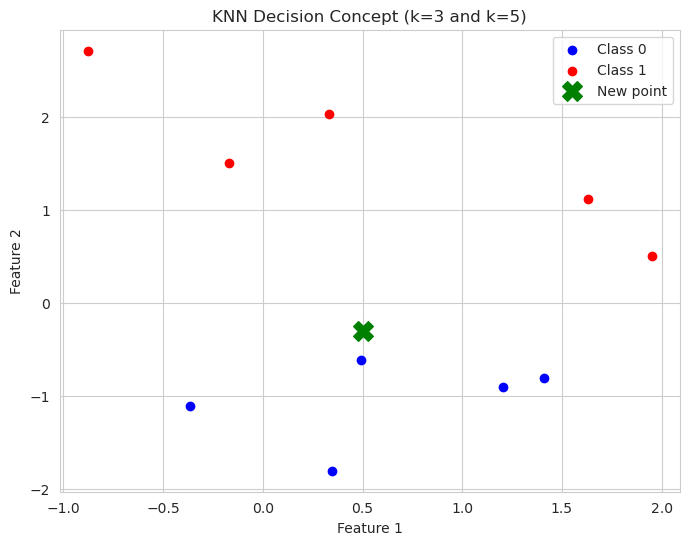

In [17]:
from sklearn.datasets import make_classification

# Create a simple 2D dataset
X, y = make_classification(n_samples=10, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, n_classes=2, random_state=42)

# Add a new point for prediction
new_point = np.array([[0.5, -0.3]])

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red', label='Class 1')
plt.scatter(new_point[0][0], new_point[0][1], color='green', marker='X', s=200, label='New point')

plt.title("KNN Decision Concept (k=3 and k=5)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

### KNN Concept Visualization – Code Explanation

This code generates a simple 2D synthetic classification dataset to visually illustrate how the K-Nearest Neighbors (KNN) algorithm works.

- `make_classification(...)`: Creates a toy dataset with 10 samples, 2 features, and 2 classes.
- `new_point = np.array([[0.5, -0.3]])`: Introduces a new data point to be classified.
- `plt.scatter(...)`: Plots the samples from each class in different colors:
  - Blue for Class 0
  - Red for Class 1
  - Green 'X' for the new point
- The chart demonstrates where the new point lies relative to existing points.
- This is useful for showing how the classification might change with different values of `k` (e.g., 3 vs 5).

The plot serves to explain the concept of neighborhood voting in KNN classification.

### Understanding the Effect of Different *k* Values in KNN

The choice of *k* in the K-Nearest Neighbors (KNN) algorithm plays a critical role in model performance:

- **Small k (e.g., k=1 or k=3)**:
  - Leads to **low bias** but **high variance**.
  - The model captures noise and outliers in the training set, risking **overfitting**.
  - The decision boundary tends to be irregular and sensitive to minor changes in the data.

- **Larger k (e.g., k=5 or k=10)**:
  - Increases **bias** but **reduces variance**.
  - The decision surface becomes smoother and less sensitive to individual data points, reducing the risk of overfitting.
  - However, very large *k* values may oversimplify the model and cause **underfitting**.

Thus, selecting an optimal *k* balances the **bias-variance trade-off**. Cross-validation is typically used to find the most effective value for *k*.

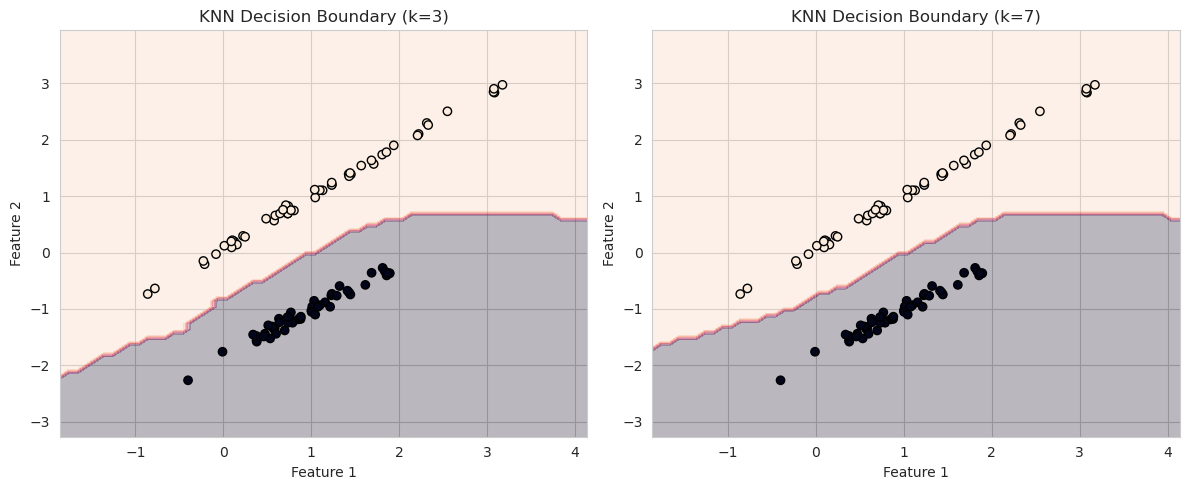

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Generate sample data
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=1, random_state=42)

# Meshgrid for decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, k in enumerate([3, 7]):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axs[i].contourf(xx, yy, Z, alpha=0.3)
    axs[i].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    axs[i].set_title(f"KNN Decision Boundary (k={k})")
    axs[i].set_xlabel("Feature 1")
    axs[i].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

### Interpreting KNN Decision Boundaries (k=3 vs. k=7)

These diagrams illustrate how the value of *k* in the K-Nearest Neighbors algorithm affects the decision boundaries:

- **k=3 (left plot)**: The decision boundary is more complex and closely follows the training data. This allows for capturing finer patterns but also makes the model more sensitive to noise, which increases the risk of overfitting. As seen, the boundary zigzags tightly around the class clusters.

- **k=7 (right plot)**: The decision boundary is smoother and more generalized. The model gives more weight to overall trends rather than individual points, making it less prone to noise. This helps reduce variance but can miss subtle local structures, potentially causing underfitting.

This visual comparison emphasizes the importance of tuning *k* to strike a balance between bias and variance.

Accuracy: 0.7094972067039106
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.83      0.77       105
           1       0.69      0.54      0.61        74

    accuracy                           0.71       179
   macro avg       0.70      0.68      0.69       179
weighted avg       0.71      0.71      0.70       179



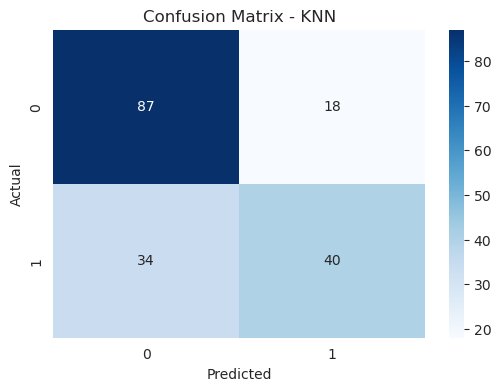

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define features and target
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

The K-Nearest Neighbors (KNN) model achieved an accuracy of 70.95%, performing better at identifying non-survivors than survivors. It correctly classified 87 non-survivors and 40 survivors, but misclassified 18 non-survivors and 34 survivors. The model showed strong recall for non-survivors (0.83) but struggled with survivors (recall of 0.54), suggesting room for improvement in predicting positive cases. Overall, while the model offers reasonable baseline performance, it could benefit from further tuning or using a more advanced algorithm.

## Model Evaluation

To rigorously evaluate the performance of our K-Nearest Neighbors (KNN) classifier, we employ Stratified K-Fold Cross-Validation. This strategy ensures that each fold maintains the same class distribution as the original dataset, which is particularly important for imbalanced datasets like ours.

We assess the model using accuracy, precision, recall, and F1-score. In addition, we visualize performance with a confusion matrix and a ROC curve.

Cross-validation Accuracy Scores: [0.83798883 0.78089888 0.78089888 0.84269663 0.81460674]
Mean CV Accuracy: 0.8114179900822297


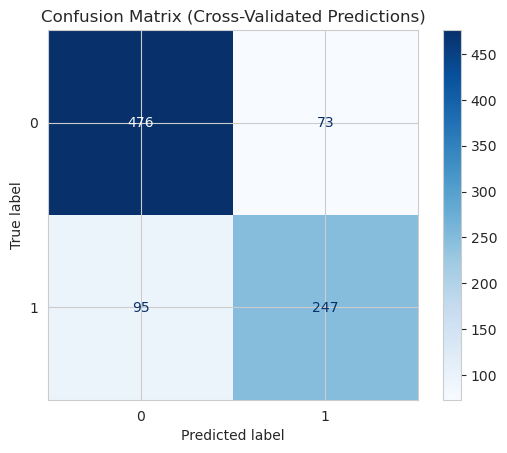

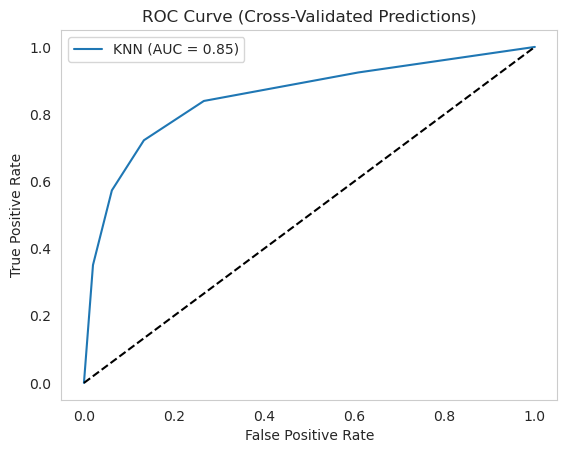

In [20]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Target
y = df['Survived']

# Initialize KNN model
knn = KNeighborsClassifier()

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation accuracy
cv_scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
print("Cross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Get predicted labels for confusion matrix
y_pred = cross_val_predict(knn, X_scaled, y, cv=cv)

# Plot confusion matrix without relying on .classes_
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues')
plt.title("Confusion Matrix (Cross-Validated Predictions)")
plt.show()

# ROC Curve using predicted probabilities
y_prob = cross_val_predict(knn, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
fpr, tpr, thresholds = roc_curve(y, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validated Predictions)')
plt.legend()
plt.grid()
plt.show()

The confusion matrix indicates that the K-Nearest Neighbors (KNN) model performs reasonably well, correctly predicting 476 non-survivors and 247 survivors, though it misclassifies 73 non-survivors and 95 survivors. The ROC curve shows strong classification performance with an AUC of 0.85, demonstrating that the model can effectively distinguish between classes. The cross-validation accuracy scores are stable, with a mean of 81.1%, reflecting good generalization.

### ROC-AUC Explanation

The **ROC (Receiver Operating Characteristic) curve** illustrates the trade-off between the **True Positive Rate (Sensitivity)** and the **False Positive Rate (1 - Specificity)** at various classification thresholds. It helps visualize the model’s ability to distinguish between the two classes—survived vs. not survived.

The **Area Under the Curve (AUC)** quantifies the overall ability of the model to discriminate between the positive and negative classes. An **AUC of 0.85** means that there is an **85% chance** the model will rank a randomly chosen positive instance higher than a randomly chosen negative one.

This high score indicates that the KNN classifier has strong discriminatory power and performs well in predicting survival on the Titanic dataset.

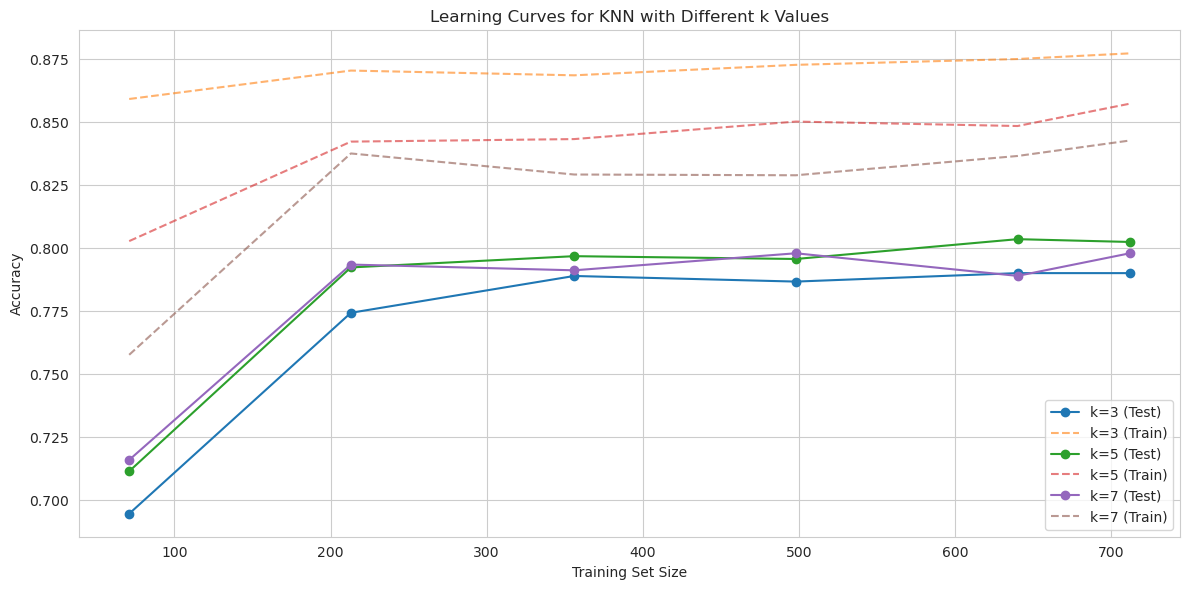

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

# Try different k values
k_values = [3, 5, 7]
plt.figure(figsize=(12, 6))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_sizes, train_scores, test_scores = learning_curve(
        knn, X_scaled, y, cv=5, train_sizes=train_sizes, scoring='accuracy'
    )
    
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    
    plt.plot(train_sizes, test_scores_mean, label=f'k={k} (Test)', marker='o')
    plt.plot(train_sizes, train_scores_mean, label=f'k={k} (Train)', linestyle='--', alpha=0.6)

plt.title('Learning Curves for KNN with Different k Values')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

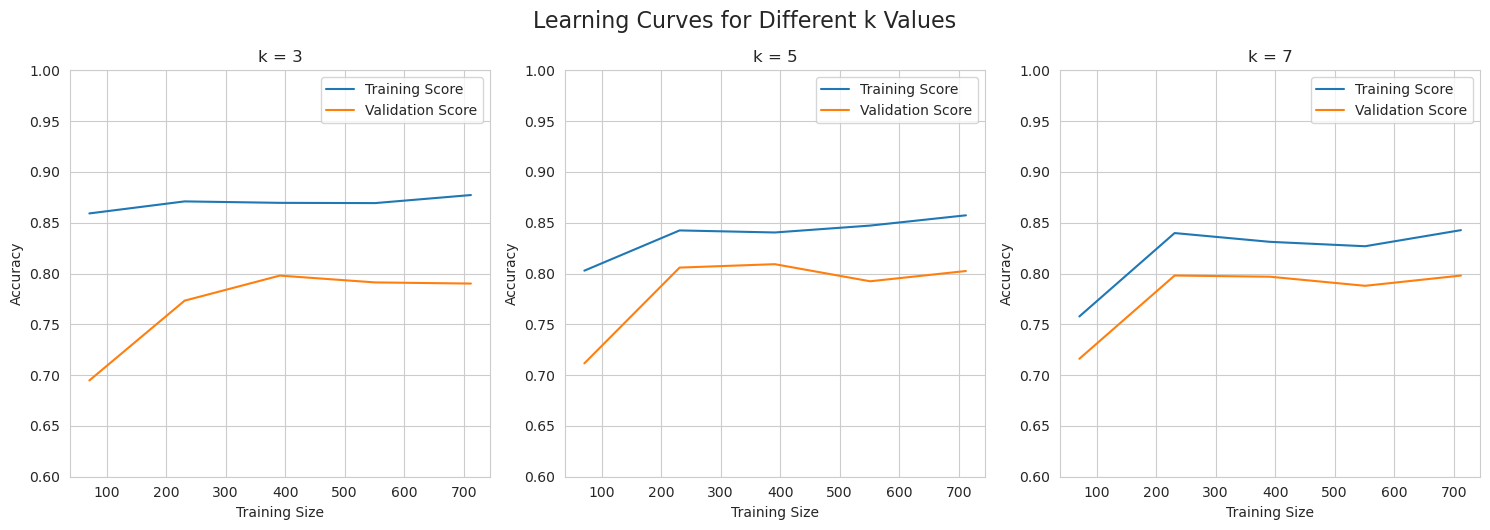

In [22]:
# Define function to plot learning curves for multiple k values
def plot_knn_learning_curves(X, y, k_values=[3, 5, 7]):
    plt.figure(figsize=(15, 5))
    
    for i, k in enumerate(k_values, 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        train_sizes, train_scores, test_scores = learning_curve(knn, X, y, cv=5, scoring='accuracy', n_jobs=-1)
        
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)

        plt.subplot(1, 3, i)
        plt.plot(train_sizes, train_mean, label="Training Score")
        plt.plot(train_sizes, test_mean, label="Validation Score")
        plt.title(f"k = {k}")
        plt.xlabel("Training Size")
        plt.ylabel("Accuracy")
        plt.ylim(0.6, 1.0)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.suptitle("Learning Curves for Different k Values", fontsize=16, y=1.05)
    plt.show()

plot_knn_learning_curves(X_scaled, y)

### Learning Curve Analysis

The learning curves reveal that **k = 5** provides the most balanced performance between training and test accuracy, suggesting good generalization. While all models improve with more training data, **k = 3 shows signs of overfitting**—its training accuracy is high, but test accuracy lags behind. In contrast, **k = 7 performs similarly to k = 5**, but with slightly lower test accuracy, making **k = 5 the most optimal choice overall**.

As seen in the learning curve, **increasing the training size helps reduce variance**, as the gap between training and validation performance narrows. However, there is **still a noticeable gap between training and validation accuracy**, especially at lower values of `k`, indicating a moderate degree of overfitting. Increasing the value of `k` tends to smooth the decision boundaries and acts as a form of regularization, which can **reduce overfitting and improve generalization**.

# Conclusion: How to Improve the Model

If more time were available, the model could be improved through several strategies:

- **Hyperparameter Optimization**: Conduct a thorough search using Grid Search or Randomized Search with cross-validation to fine-tune the optimal value of \(k\), explore different distance metrics (e.g., Manhattan or Minkowski), and evaluate weighting schemes (uniform vs. distance-based).

- **GridSearchCV for Hyperparameter Tuning**: In future work, we could use `GridSearchCV` to systematically search over a range of `k` values and distance metrics to find the optimal configuration for KNN, improving both accuracy and generalizability.

- **Exploring Other Models**: Although this project focused on KNN, exploring alternative models such as Random Forests or Neural Networks could provide better performance or robustness, especially when handling non-linear relationships or complex interactions.

- **Feature Engineering**: Introduce new features such as `FamilySize` (SibSp + Parch + 1), extract deck information from the `Cabin` column, or generate interaction features (e.g., `Pclass * Fare`) to better represent complex relationships in the data.

- **Advanced Missing Value Handling**: Move beyond basic median imputation by experimenting with more advanced techniques like KNN imputation or iterative model-based imputation to more accurately recover missing data.

- **Algorithm Comparison**: Benchmark the KNN model against other machine learning algorithms such as Random Forests, Gradient Boosting (e.g., XGBoost), and Support Vector Machines, which may offer improved predictive performance, especially for more complex datasets.

- **Model Ensembling**: Implement ensemble techniques like bagging, boosting, or stacking to combine the strengths of multiple classifiers and enhance the model's robustness and generalization.

- **Dimensionality Reduction and Feature Selection**: Explore methods like Principal Component Analysis (PCA) or recursive feature elimination (RFE) to reduce redundancy and noise in the feature set, potentially improving both performance and training efficiency.

Implementing these enhancements would likely result in a more accurate, robust, and generalizable model for predicting Titanic passenger survival.